# Discovery of chandelier cell growth cones

In [207]:
import sys
import os
import numpy as np
import pickle as pkl
from sklearn import decomposition, ensemble, model_selection, cluster
from matplotlib import pyplot as plt
import pandas as pd 
import glob
from meshparty import trimesh_io
import h5py
import re
import itertools

cwd = os.getcwd()
cwd = cwd[: -(1 + len(cwd.split("/")[-1]))] + "/neuronencodings"
sys.path.append(cwd)

HOME = os.path.expanduser("~")

import neuronencodings as ne

In [208]:
meshmeta = trimesh_io.MeshMeta()

## Load meshes

In [209]:
mesh_dir = "%s/seungmount/research/svenmd/InhAnalysis/meshes_Chandelier/" % HOME
mesh_files = glob.glob(mesh_dir + "/*")

In [210]:
cell_meshes = {}

for path in mesh_files:
    cell_id = int(re.findall("[\d]+", os.path.basename(path))[0])
    
    mesh = meshmeta.mesh(path)
    if len(mesh.vertices) >= 1000 and len(mesh.vertices) < 100000:
        print(len(mesh.vertices))
        cell_meshes[cell_id] = mesh

10525
5352
57084
43156
72805
23968
16216
53583
3166
12561
11982
8164
82397
25087
7149
3039
9632
3364
25591
23312
37665
1363
11891
53346
11051
5994
38869
1023
91722
1371
12188
5688
8912
16486
3853
26672
48174
14356
32534
31450
64847
3425
4795
65315
6266
6945
8302
59760
43908
12824
65219
6626
26245
4670
4671
14349
15680
16498
14432
27406
9818
49317
2154
8283
3273
5154
12244
11889
48931
11998
78156
5851
6450
11154
32250
25318
7860
23438
4295
9442
2316
84074
10479
3944
12660
22678
89158
3694
4333
58000
7356
13144
17981
8070
24659
14270
25824
29104
4114
63260
44916
12246
6805
36633
60964
1929
6505
17223
68373
68878
35937
52629
11350
12639
2513
1077
4200
65787
18047
48770
20050
40153
3671
11328
54198
8540
30348
50610
22227
6700
29107
19692
17095
92353
6089
4092
29438
4821
7485
34222
4327
33848
22440
22229
28568
3697
22948
29596
10149
7478
19719
69230
2930
65432
36381
11183
2728
24787
3916
31876
60247
32518
31717
8327
34709
10339
12556
8309
6766
11413
4850
21125
10235
2869
29918
29375
29472
7

In [211]:
meshes = list(cell_meshes.values())
cell_ids = np.array(list(cell_meshes.keys()))

## Load interesting locations

In [212]:
pois = [[1108979055853, [69890.9453125, 54838.8828125, 996.9571533203125]], [1584500104278, [75022.375, 64504.5234375, 1610.593994140625]], [1584500104278, [75335.984375, 65065.421875, 1651.032470703125]], [1181850724185, [78250.1015625, 54076.08984375, 635.516845703125]], [1176074954357, [76088.0546875, 48486.78125, 1576.953857421875]], [1319536680537, [87069.6796875, 46405.23828125, 1592.8033447265625]], [1038103211178, [87933.3515625, 50646.80078125, 1625.3172607421875]], [1038103211178, [87959.9296875, 51400.9921875, 1654.3670654296875]], [1389271720426, [91283.359375, 52350.79296875, 711.7086181640625]], [573349317266, [88651.2890625, 53750.7265625, 1615.7994384765625]], [573349317266, [88543.4375, 53284.59375, 1615.7994384765625]], [2014742838723, [102381.3984375, 57303.16796875, 892.7685546875]], [2014742838723, [101922.4140625, 58047.44140625, 925.5048828125]], [2014742838723, [101769.3359375, 58788.171875, 941.7863159179688]], [2014742838723, [99689.484375, 43676.15625, 318.900390625]], [1441251077245, [90029.5859375, 57411.9765625, 1606.653564453125]], [1410163802105, [90565.25, 55367.1328125, 1582.2000732421875]], [1410163802105, [90384.375, 55746.96875, 1586.35546875]], [1441251077245, [90499.6171875, 55113.05859375, 1584.9373779296875]], [1441251077245, [90335.9765625, 55842.00390625, 1589.9373779296875]], [1982371020342, [81322.8515625, 51341.16015625, 126.96614837646484]], [1161528965440, [81257.5390625, 50663.6640625, 113.00162506103516]], [1161528965440, [81480.1796875, 49621.91015625, 64.06420135498047]], [1161528965440, [80737.671875, 50948.8203125, 250.8614959716797]], [1161528965440, [99814.609375, 45662.171875, 515.2481079101562]], [1161528965440, [99667.90625, 46550.3203125, 556.5179443359375]]]

poi_seg_ids = np.array([poi[0] for poi in pois])
pois_filtered = []

for poi in pois:
    if poi[0] in cell_ids:
        pois_filtered.append(poi)

In [213]:
len(pois_filtered)

17

In [214]:
poi_meshes = []

for poi in pois_filtered:
    mesh = cell_meshes[poi[0]]
    center_coord = np.array(poi[1]) * np.array([4, 4, 40])
    
    offsets = itertools.product(range(-500, 600, 250), 
                                range(-500, 600, 250), 
                                range(-50, 60, 25))
#     offsets = [[0, 0, 0]]
    for offset in offsets:
        this_center_coord = center_coord + np.array(offset)
        local_verts = mesh.get_local_view(n_pts, center_coord=this_center_coord)
        local_mesh = trimesh_io.Mesh(vertices=local_verts[0])
        poi_meshes.append(local_mesh)

## Load model

In [216]:
n_pts = 1000
chkpt_fname = "%s/seungmount/research/nick_and_sven/models_sven/pinky100_chandelier_ae_1000_local_nomorm_v3/models/model_551000.chkpt" % HOME
model = ne.utils.load_autoencoder("PointNetAE", n_pts=1000, bottle_fs=64, chkpt_fname=chkpt_fname, eval_=True, bn=False)

## Prediction

In [217]:
all_vecs, all_center_inds = ne.pred.encode_meshs_by_views(model, meshes, n_points=n_pts, pc_align=True, order="sequential")

In [218]:
vecs = []
for vec in all_vecs:
    vecs.extend(vec)

In [219]:
poi_vecs, poi_center_inds = ne.pred.encode_meshs_by_views(model, poi_meshes, n_points=n_pts, pc_align=True, order="sequential")

## Latent vectors (full cell)

In [220]:
def hist_1d(arr):
    """ 1d histogram along axis for feature extraction """
    return np.histogram(arr / arr.max(), bins=np.linspace(0, 1, 11))[0]


def feat_stats(arr):
    """ Simple statistics """
    return np.concatenate([np.mean(arr, axis=0),
                           np.median(arr, axis=0),
                           np.var(arr, axis=0)])


def combine_views(views, use_hist=False):
    """ Simple statistics to combine views from same cell / entity """
    views = np.array(views).copy()

    feats = feat_stats(views)

    if use_hist:
        hist = np.apply_along_axis(hist_1d, axis=1, arr=views)
        feats = np.concatenate([feat_stats(hist), feats])

    return feats

def pca(features, ndims=10):
    """ Applies PCA to features / views """

    features_n = features.copy()
    std = np.std(features_n, axis=0)[None]
    std[std == 0] = 1
    features_n /= std
    features_n -= np.nanmean(features_n, axis=0)[None]

    pca = decomposition.PCA(n_components=ndims)
    features_t = pca.fit_transform(features_n)

    return features_t

In [221]:
latent_vecs = []

for vec in all_vecs:
    latent_vecs.append(combine_views(vec, use_hist=True))
    
latent_vecs = np.array(latent_vecs)
latent_vecs_pca = pca(latent_vecs)

/usr/people/svenmd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


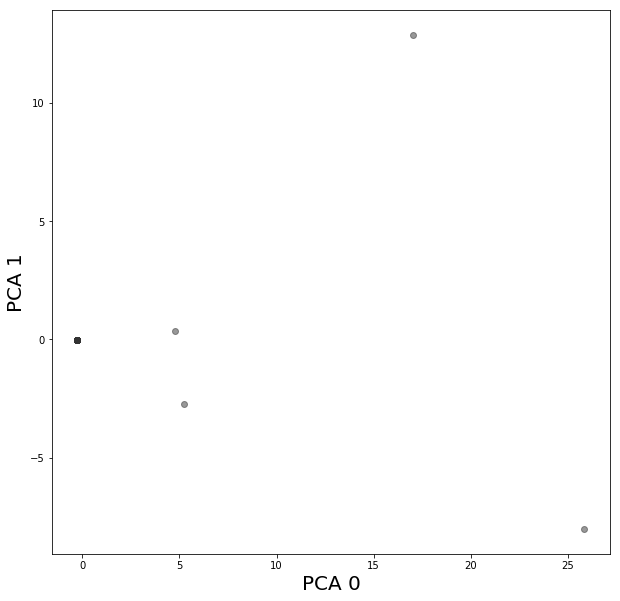

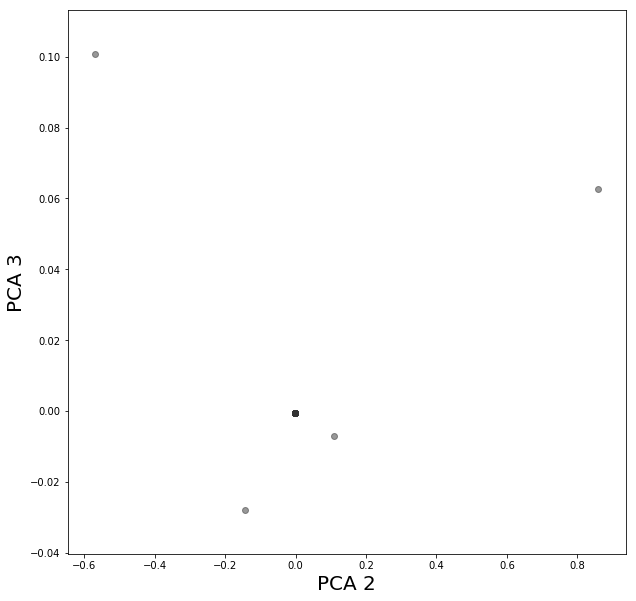

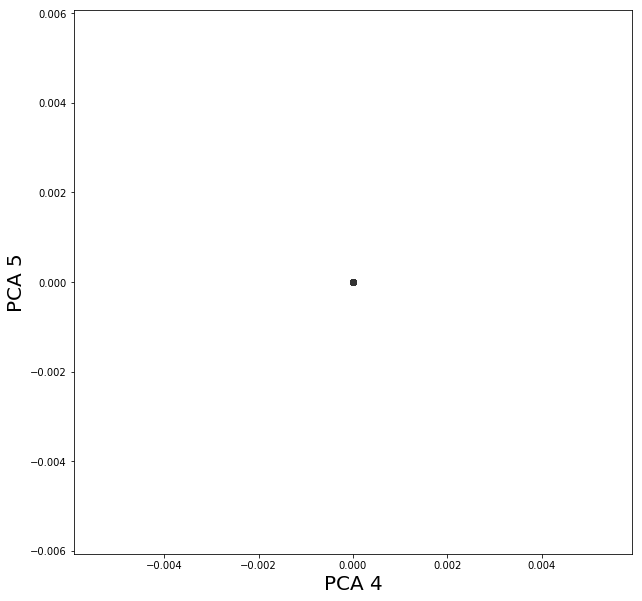

In [222]:
for axis in [[0, 1], [2, 3], [4, 5]]:
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_vecs_pca[:, axis[0]], latent_vecs_pca[:, axis[1]], alpha=.5, c=".2")

    plt.xlabel("PCA %d" % axis[0], fontsize=20)
    plt.ylabel("PCA %d" % axis[1], fontsize=20)

    plt.show()

## Latent vectors (local views)

In [223]:
poi_vecs = np.array(poi_vecs)[:, 0]

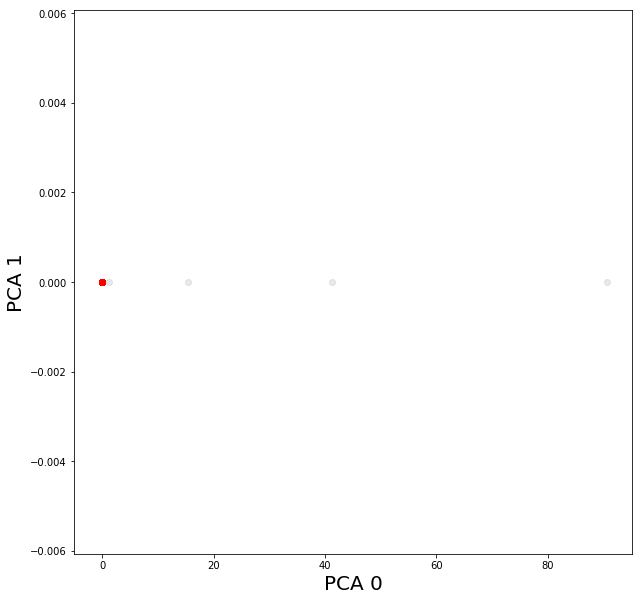

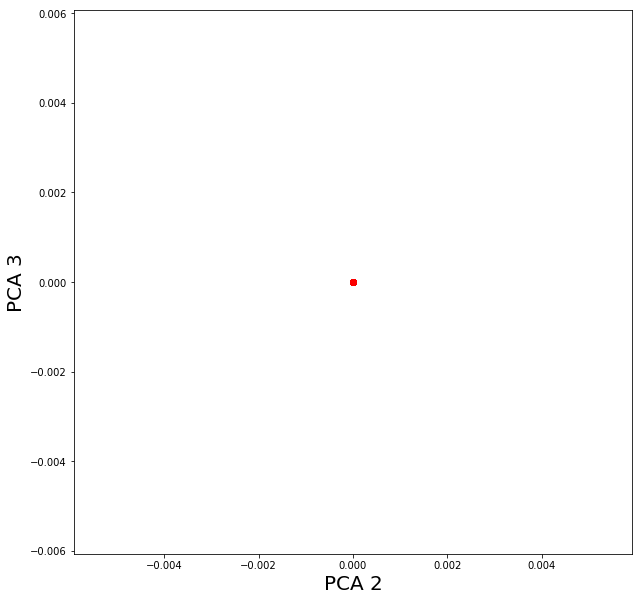

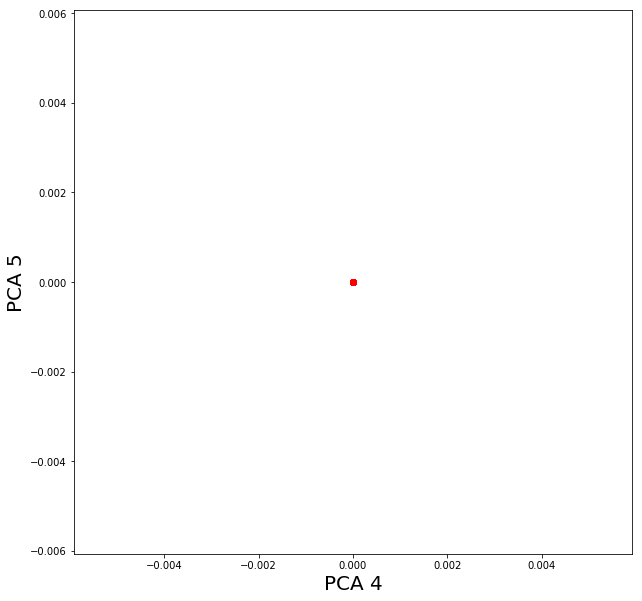

In [224]:
latent_vecs = np.array(np.concatenate([poi_vecs, vecs]))
latent_vecs_pca = pca(latent_vecs)

for axis in [[0, 1], [2, 3], [4, 5]]:
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_vecs_pca[len(poi_vecs):, axis[0]], 
                latent_vecs_pca[len(poi_vecs):, axis[1]], 
                alpha=.1, c=".2")

    plt.scatter(latent_vecs_pca[:len(poi_vecs), axis[0]], 
                latent_vecs_pca[:len(poi_vecs), axis[1]], 
                alpha=.25, c="r")
    
    plt.xlabel("PCA %d" % axis[0], fontsize=20)
    plt.ylabel("PCA %d" % axis[1], fontsize=20)

    plt.show()